# 時間序列(Time Series)預測 
### 程式修改自 [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ln -fs /content/gdrive/My\ Drive/DL_Book /app
%cd /app
!ls

/content/gdrive/My Drive/DL_Book
 audio		    images_Object_Detection   src
 cascade_files	    images_ocr		      static
 chatbot_data	    images_test		      style_transfer
 Custom_data	    jieba		     'Tensorflow 安裝.md'
 data		    lib			      TicTacToe_1
 data_download.md   MaskRCNN_weights	      video
 data.zip	    myDigits		      YOLO4
 dialogflow	    NLP_data		      YOLO_weights
 FAQ		    rasa		      勘誤表.md
 images		    README.md		      封面1.jpeg
 images_face	    RNN


In [3]:
# 載入相關套件
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 載入測試資料
df = pd.read_csv('./RNN/monthly-airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 10 Text major ticklabel objects>)

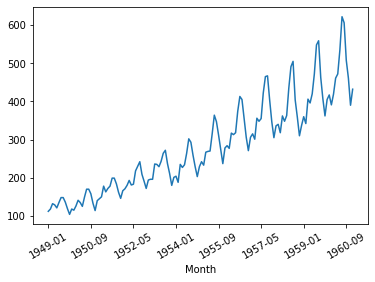

In [9]:
# 繪圖
df2 = df.set_index('Month')
df2.plot(legend=None)
plt.xticks(rotation=30)

In [10]:
# 轉換資料
from sklearn.preprocessing import MinMaxScaler

# 函數：以前期資料為 X，當前期資料為 Y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

dataset = df2.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當期資料為 Y
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# 訓練模型
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# 模型評估
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
94/94 [==============================] - 2s 2ms/step - loss: 0.0437
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 11/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 12/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 13/100
94/94 [=================

Train Score: 23.00 RMSE
Test Score: 48.85 RMSE


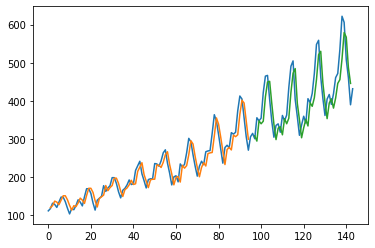

In [12]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 改變Loopback=3：X由前1期改為前3期 

In [13]:
# 載入測試資料
df = pd.read_csv('./RNN/monthly-airline-passengers.csv', usecols=[1])
print(df.head())
dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

   Passengers
0         112
1         118
2         132
3         129
4         121


In [ ]:
dataset

In [15]:
trainX.shape

(92, 1, 3)

In [16]:
# 訓練模型
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# 模型評估
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
92/92 [==============================] - 1s 2ms/step - loss: 0.0317
Epoch 2/100
92/92 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 3/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 4/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 5/100
92/92 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 6/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 7/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 8/100
92/92 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 9/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 10/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 11/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 12/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 13/100
92/92 [=================

Train Score: 24.59 RMSE
Test Score: 64.68 RMSE


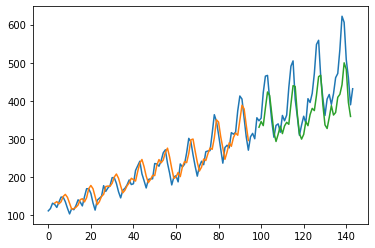

In [17]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 改變落後期數(Time Steps)：X由t-1期改為t-3期(單期) 

In [18]:
# 載入測試資料
df = pd.read_csv('./RNN/monthly-airline-passengers.csv', usecols=[1])

dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [19]:
trainX.shape

(92, 3, 1)

In [20]:
# 訓練模型
model = Sequential()
# (1, look_back) 改為 (look_back, 1)
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

# 模型評估
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
92/92 [==============================] - 2s 2ms/step - loss: 0.0181
Epoch 2/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 3/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 4/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 5/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 6/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 7/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 8/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 9/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 10/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 11/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 12/100
92/92 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 13/100
92/92 [=================

Train Score: 24.56 RMSE
Test Score: 62.16 RMSE


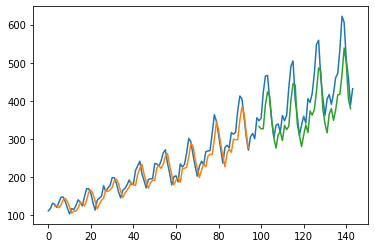

In [21]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## stateful=True

In [22]:
# 載入測試資料
df = pd.read_csv('./RNN/monthly-airline-passengers.csv', usecols=[1])

dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [23]:
# 訓練模型
model = Sequential()
# (1, look_back) 改為 (look_back, 1)
# model.add(LSTM(4, input_shape=(look_back, 1)))
batch_size = 1
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, 
              shuffle=False, verbose=2)
    # 重置狀態(cell state)
    model.reset_states()

# 模型評估
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

92/92 - 2s - loss: 0.0220
92/92 - 0s - loss: 0.0284
92/92 - 0s - loss: 0.0191
92/92 - 0s - loss: 0.0160
92/92 - 0s - loss: 0.0133
92/92 - 0s - loss: 0.0107
92/92 - 0s - loss: 0.0084
92/92 - 0s - loss: 0.0066
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0042
92/92 - 0s - loss: 0.0042
92/92 - 0s -

Train Score: 26.81 RMSE
Test Score: 62.98 RMSE


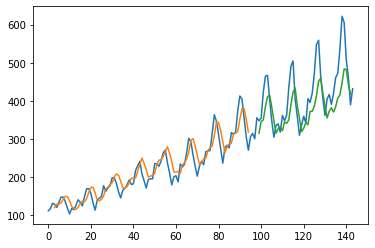

In [24]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stacked LSTM

In [25]:
# 載入測試資料
df = pd.read_csv('./RNN/monthly-airline-passengers.csv', usecols=[1])

dataset = df.values
dataset = dataset.astype('float32')

# X 常態化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# 以前期資料為 X，當前期資料為 Y
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 轉換為三維 [筆數, 落後期數, X維度]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [26]:
# 訓練模型
model = Sequential()
# (1, look_back) 改為 (look_back, 1)
# model.add(LSTM(4, input_shape=(look_back, 1)))
batch_size = 1

# Stacked LSTM
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1),
               stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1),
               stateful=True))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, 
              shuffle=False, verbose=2)
    # 重置狀態(cell state)
    model.reset_states()

# 模型評估
trainPredict = model.predict(trainX, batch_size=batch_size)
# 重置狀態(cell state)
model.reset_states() 
testPredict = model.predict(testX, batch_size=batch_size)

92/92 - 3s - loss: 0.0050
92/92 - 0s - loss: 0.0115
92/92 - 0s - loss: 0.0082
92/92 - 0s - loss: 0.0065
92/92 - 0s - loss: 0.0062
92/92 - 0s - loss: 0.0061
92/92 - 0s - loss: 0.0061
92/92 - 0s - loss: 0.0060
92/92 - 0s - loss: 0.0059
92/92 - 0s - loss: 0.0059
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0058
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0057
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0056
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0055
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0054
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0053
92/92 - 0s - loss: 0.0052
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0051
92/92 - 0s - loss: 0.0050
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0049
92/92 - 0s - loss: 0.0048
92/92 - 0s - loss: 0.0047
92/92 - 0s - loss: 0.0046
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0045
92/92 - 0s - loss: 0.0044
92/92 - 0s - loss: 0.0043
92/92 - 0s - loss: 0.0042
92/92 - 0s -

Train Score: 29.16 RMSE
Test Score: 119.46 RMSE


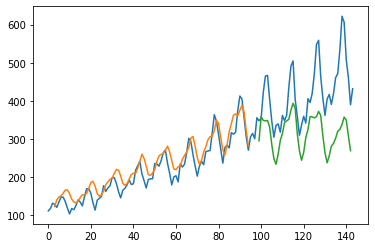

In [27]:
from sklearn.metrics import mean_squared_error
import math 

# 還原常態化的訓練資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()